In [34]:
# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import  FISTA, HybridGLSQR, GLSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve, UpdateRegReginska, UpdateRegUPRE

# Third-party imports
import numpy as np
from time import time    

# CIL imports for data loading and visualisation
from cil.utilities.display import show2D

## Load Data
In this example, we utilize CIL's simulated sphere data. To accelerate computations in this notebook, we extract a 2D slice from the 3D dataset. Additionally, we select a subset of angles to create a limited-angle reconstruction scenario. We will then compare the ground truth data with a filtered back projection (FBP) reconstruction under these limited-angle conditions.

New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.]
	Rotation axis position: [0., 0.]
	Detector position: [    0., 60000.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [128   1]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128)
New geometry shape:  (60, 128)
FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



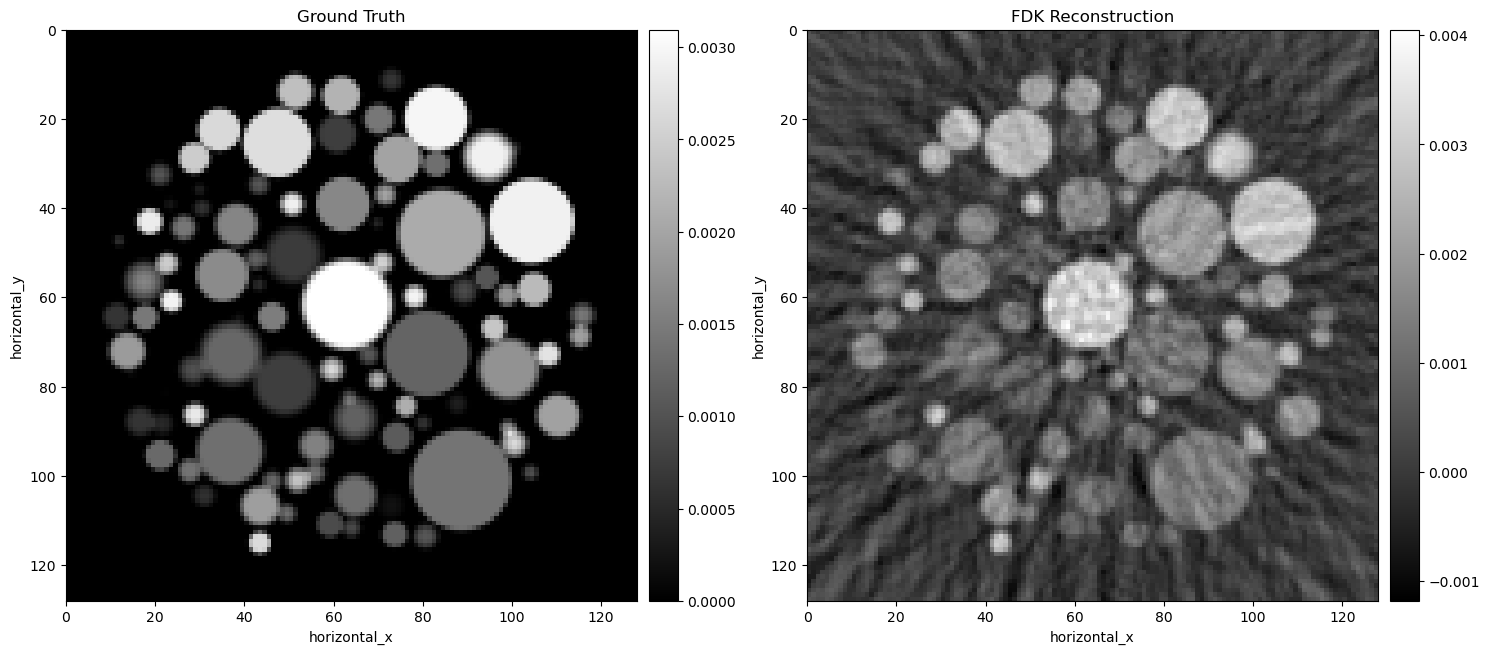

In [35]:
from data_loader import load_and_process_sphere

# Load data
data, A, ig, ground_truth = load_and_process_sphere(angle_step=5)

# Set up Initial
initial = A.domain_geometry().allocate(0)

## Hybrid methods in action L1 Regularization

1. Discrepency
2. GCV
3. Weighted GCV
4. Adaptive Weighted GCV
5. Reginska
6. UPRE
7. L-curve


In [36]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-2
maxit = 100

# Define noise level
noise_std = 0.1 * np.std(data.array) 
noiselevel = 0.1 * np.linalg.norm(data.array)
noisevariance = noise_std**2

## 1. Discrepency Rule

In [37]:
discrep_rule = UpdateRegDiscrep(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_level_estimate=noiselevel)

hybridlsqrD = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=discrep_rule)
t_start = time()
hybridlsqrD.run(maxit, verbose=True)
t_end = time()
print(f"Discrepancy rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

Discrepancy rule took 0.46112608909606934 seconds.


The optimal parameter it finds is 98.67771305721455 in 14 iterations


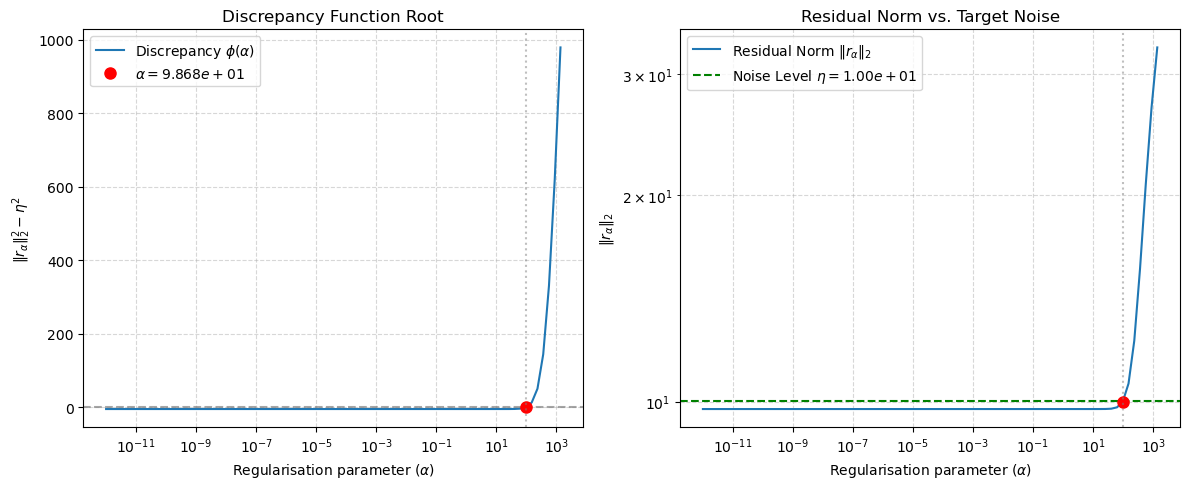

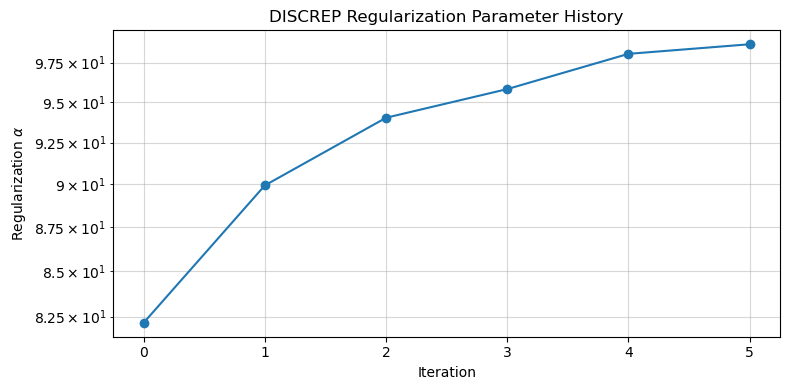

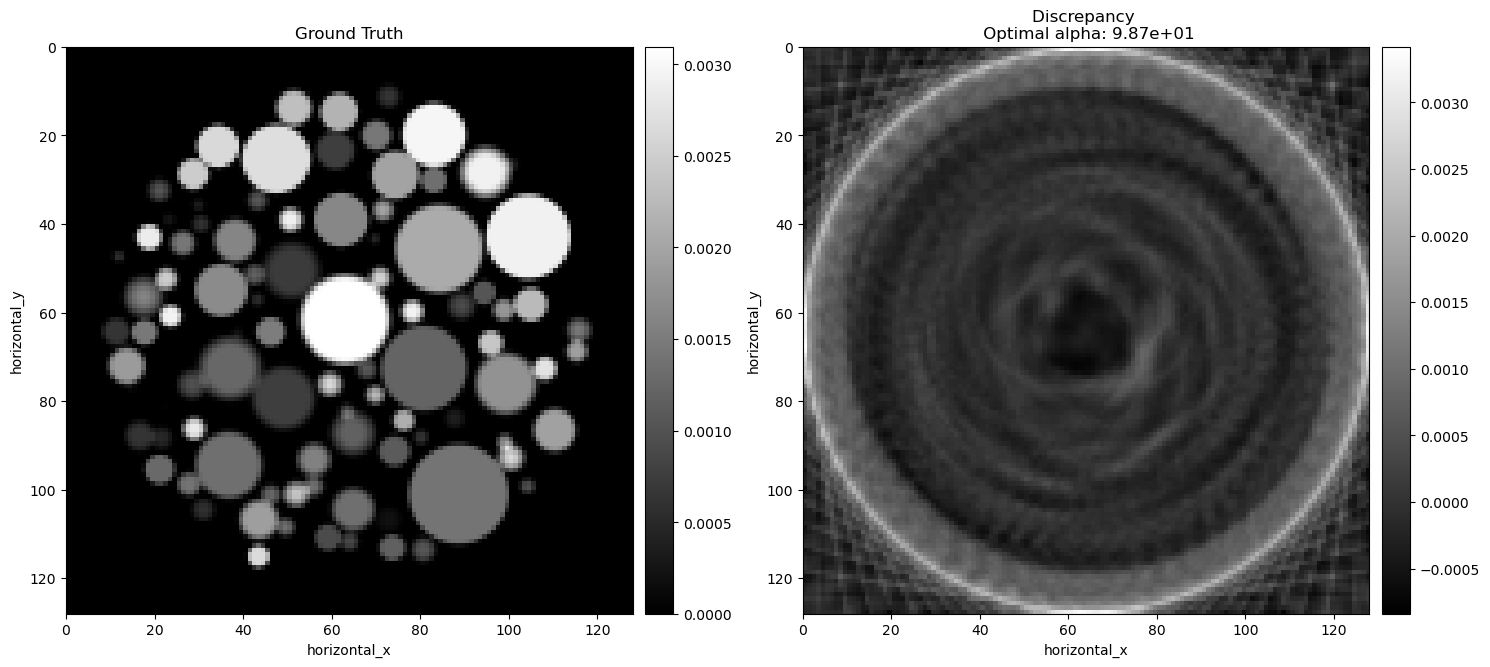

In [38]:
print("The optimal parameter it finds is", hybridlsqrD.regalpha, "in", hybridlsqrD.iteration, "iterations")

hybridlsqrD.reg_rule.plot_function()
try:  
    hybridlsqrD.reg_rule.plot_history()
except:
    pass

show2D([ground_truth, hybridlsqrD.solution], title = ['Ground Truth', f"Discrepancy \n Optimal alpha: {hybridlsqrD.regalpha:.2e}"], origin = 'upper', num_cols = 2)

## 2. Standard GCV Rule

In [39]:
gcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                adaptive_weight=False)

hybridlsqrgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                           reg_norm_type='L2', hybrid_reg_rule=gcv_rule)
t_start = time()
hybridlsqrgcv.run(maxit, verbose=True)
t_end = time()
print(f"GCV rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

GCV rule took 0.3150506019592285 seconds.


The optimal parameter it finds is 963.3092785284284 in 4 iterations


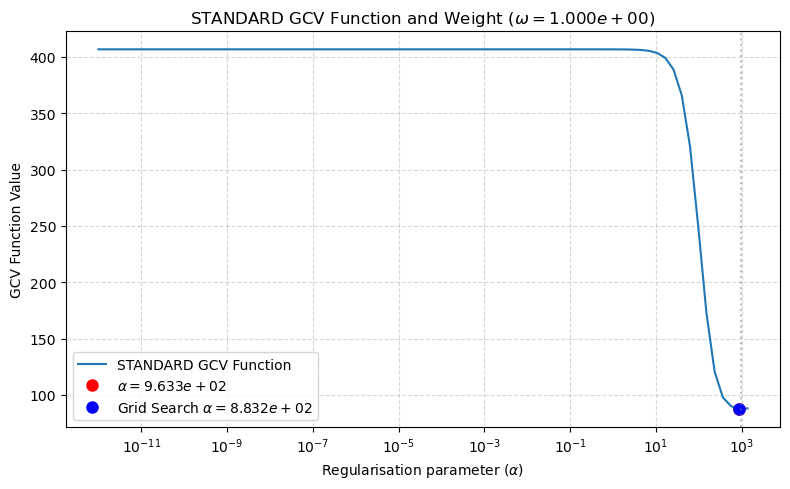

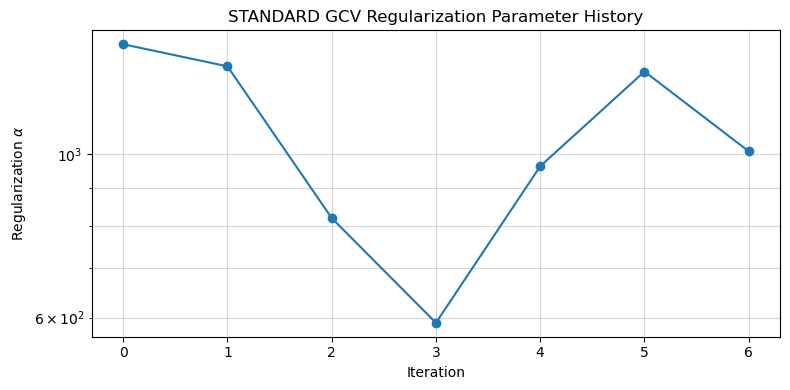

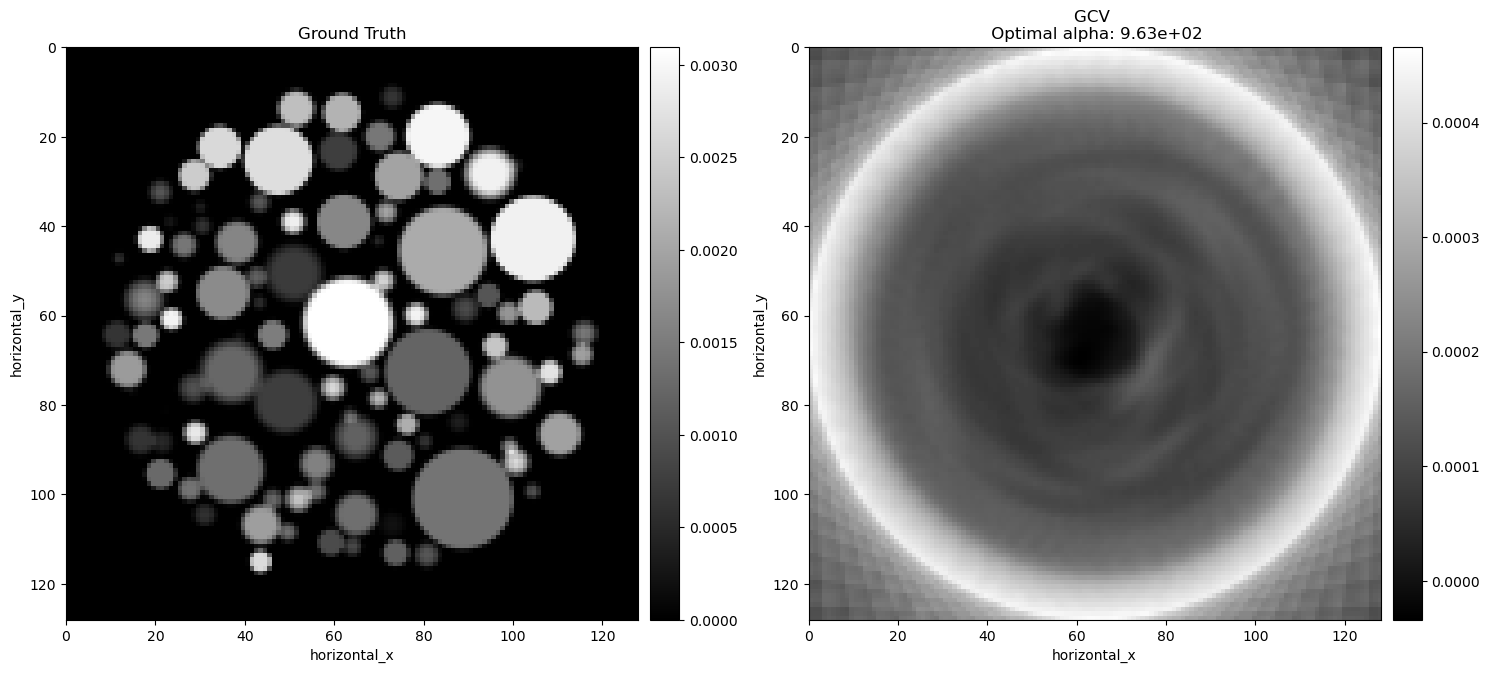

In [40]:
print("The optimal parameter it finds is", hybridlsqrgcv.regalpha, "in", hybridlsqrgcv.iteration, "iterations")

hybridlsqrgcv.reg_rule.plot_function()
hybridlsqrgcv.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrgcv.solution], title = ['Ground Truth', f"GCV \n Optimal alpha: {hybridlsqrgcv.regalpha:.2e}"], origin = 'upper', num_cols = 2)

## 3. Weighted GCV Rule

In [41]:
wgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=False)

hybridlsqrwgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            reg_norm_type='L2', hybrid_reg_rule=wgcv_rule)
t_start = time()
hybridlsqrwgcv.run(maxit, verbose=True)
t_end = time()
print(f"WGCV rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

WGCV rule took 0.2520945072174072 seconds.


The optimal parameter it finds is 150.69073105962926 in 7 iterations


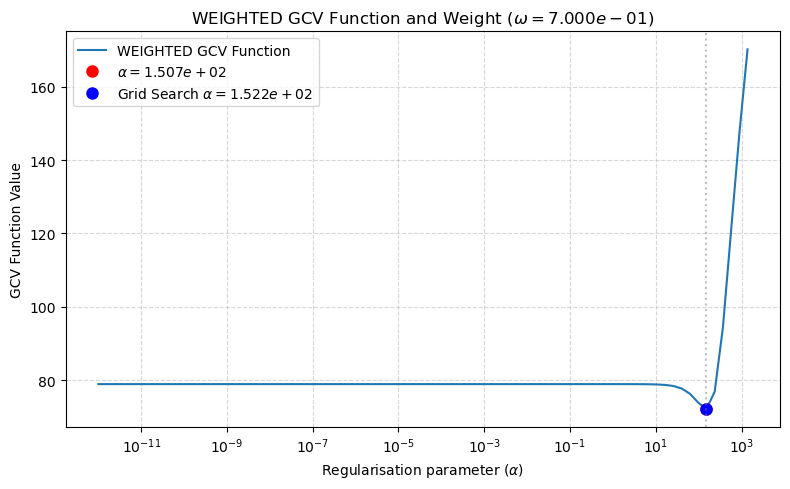

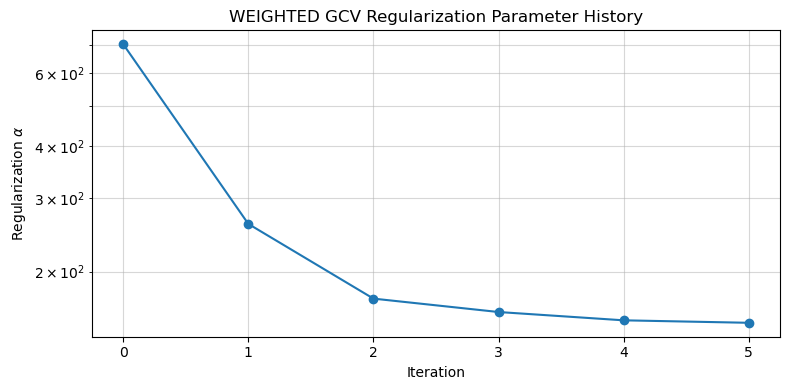

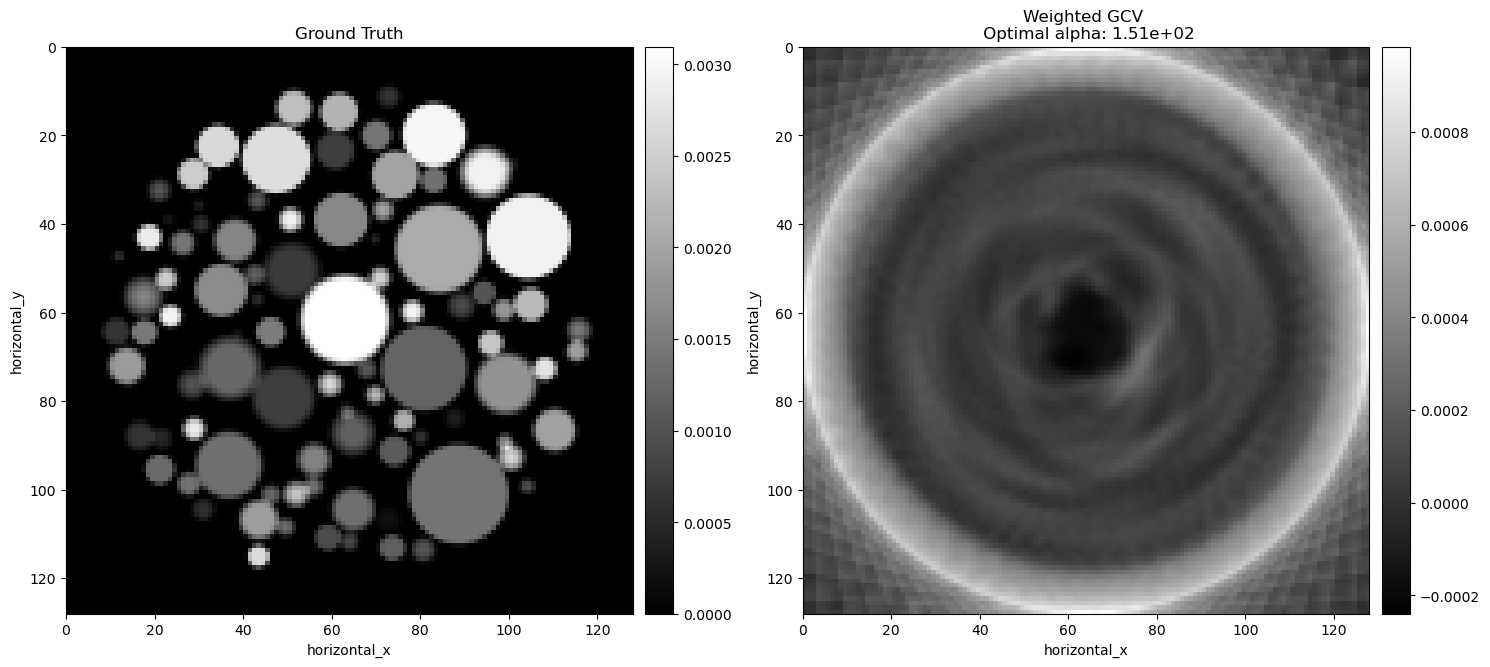

In [42]:
print("The optimal parameter it finds is", hybridlsqrwgcv.regalpha, "in", hybridlsqrwgcv.iteration, "iterations")

hybridlsqrwgcv.reg_rule.plot_function()
hybridlsqrwgcv.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrwgcv.solution], title = ['Ground Truth', f"Weighted GCV \n Optimal alpha: {hybridlsqrwgcv.regalpha:.2e}"], origin = 'upper', num_cols = 2)

## 4. Adaptive-Weighted GCV Rule

In [43]:
awgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=True)

hybridlsqrawgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                              reg_norm_type='L2', hybrid_reg_rule=awgcv_rule)
t_start = time()
hybridlsqrawgcv.run(maxit, verbose=True)
t_end = time()
print(f"Adaptive WGCV rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

Adaptive WGCV rule took 0.21004366874694824 seconds.


The optimal parameter it finds is 172.34123093457652 in 6 iterations


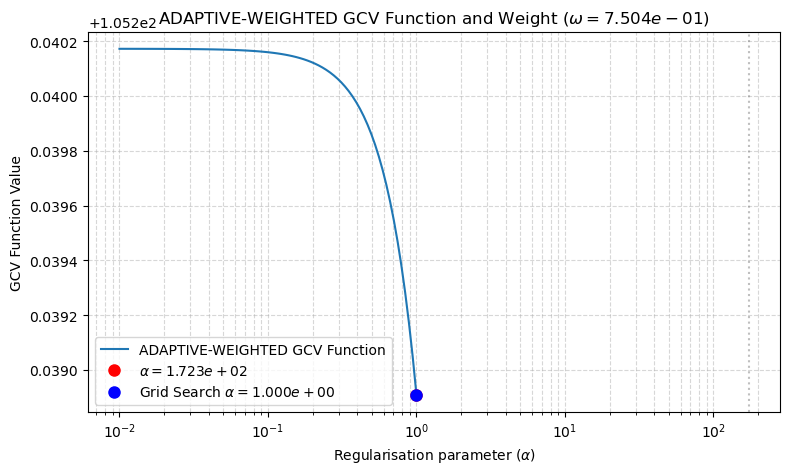

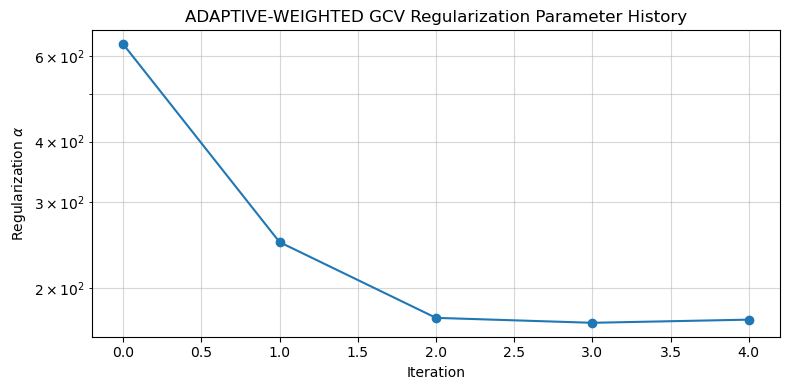

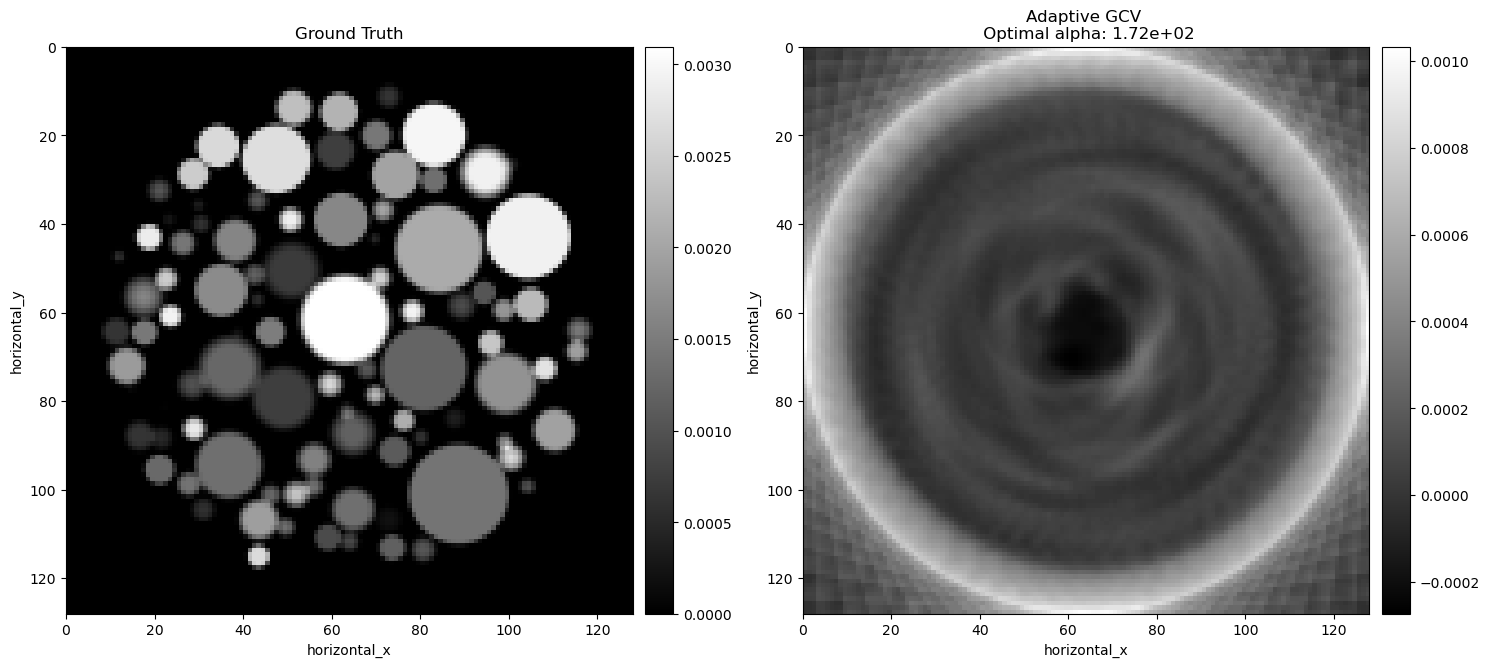

In [44]:
print("The optimal parameter it finds is", hybridlsqrawgcv.regalpha, "in", hybridlsqrawgcv.iteration, "iterations")

hybridlsqrawgcv.reg_rule.plot_function(regalpha_limits=(1e-2, 1))
hybridlsqrawgcv.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrawgcv.solution], title = ['Ground Truth', f"Adaptive GCV \n Optimal alpha: {hybridlsqrawgcv.regalpha:.2e}"], origin = 'upper', num_cols = 2)

## 5. Reginska Rule

In [45]:
reginska_rule = UpdateRegReginska(data_size=data.size,
                                domain_size=initial.size, 
                                tol=1e-3,
                                mu=0.5)

hybridlsqrreginska = HybridGLSQR(operator=A, data=data, initial=initial,
                                 reg_norm_type='L2', hybrid_reg_rule=reginska_rule)
t_start = time()
hybridlsqrreginska.run(maxit, verbose=True)
t_end = time()
print(f"Reginska rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

Reginska rule took 0.8858428001403809 seconds.


The optimal parameter it finds is 102.35452073153999 in 17 iterations


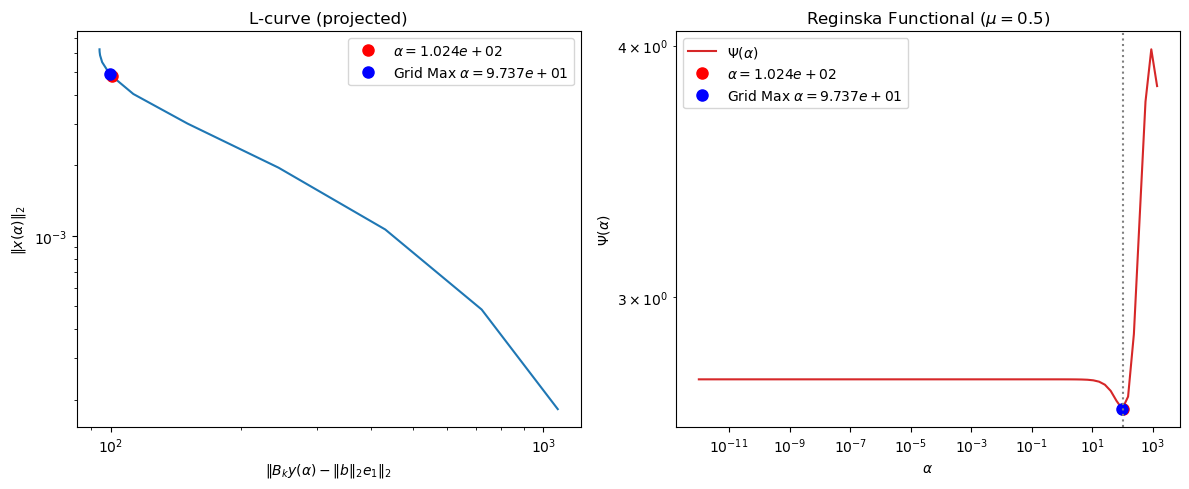

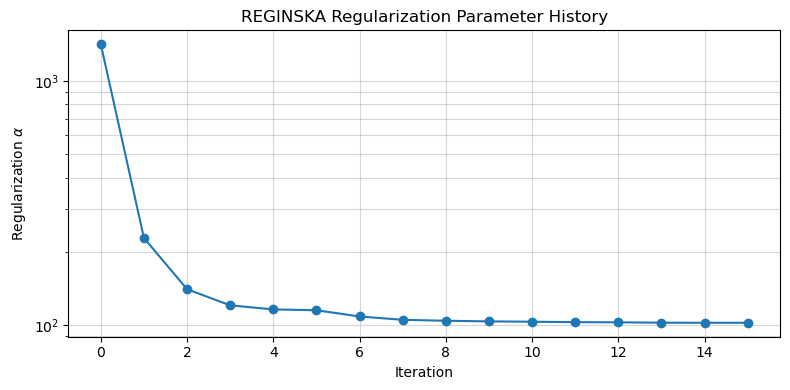

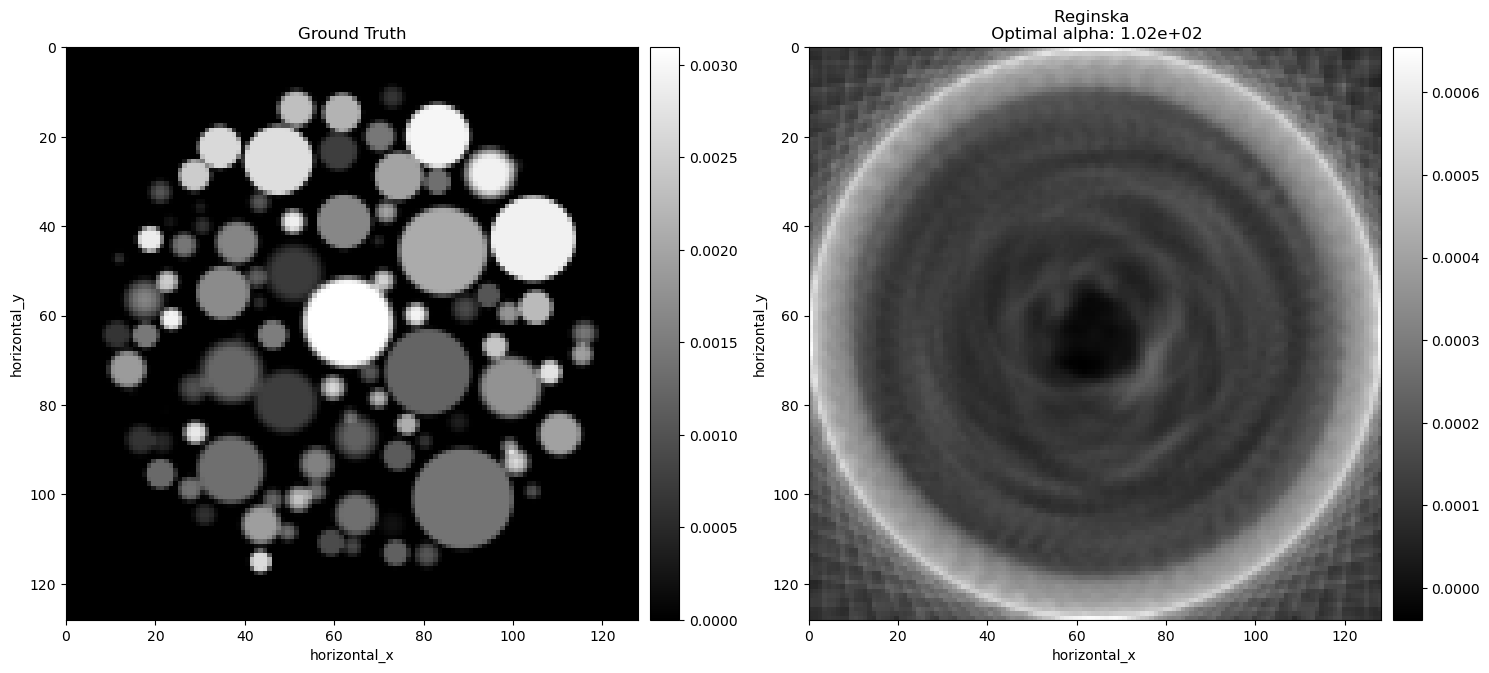

In [46]:
print("The optimal parameter it finds is", hybridlsqrreginska.regalpha, "in", hybridlsqrreginska.iteration, "iterations")

hybridlsqrreginska.reg_rule.plot_function()
hybridlsqrreginska.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrreginska.solution], title = ['Ground Truth', f"Reginska \n Optimal alpha: {hybridlsqrreginska.regalpha:.2e}"], origin = 'upper', num_cols = 2)

## 5. UPRE Rule

In [47]:
upre_rule = UpdateRegUPRE(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_variance=noisevariance)

hybridlsqrupre = HybridGLSQR(operator=A, data=data, initial=initial,
                             reg_norm_type='L2', hybrid_reg_rule=upre_rule)
t_start = time()
hybridlsqrupre.run(maxit, verbose=True)
t_end = time()
print(f"UPRE rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

UPRE rule took 0.14218950271606445 seconds.


The optimal parameter it finds is 0.7588580567133265 in 4 iterations


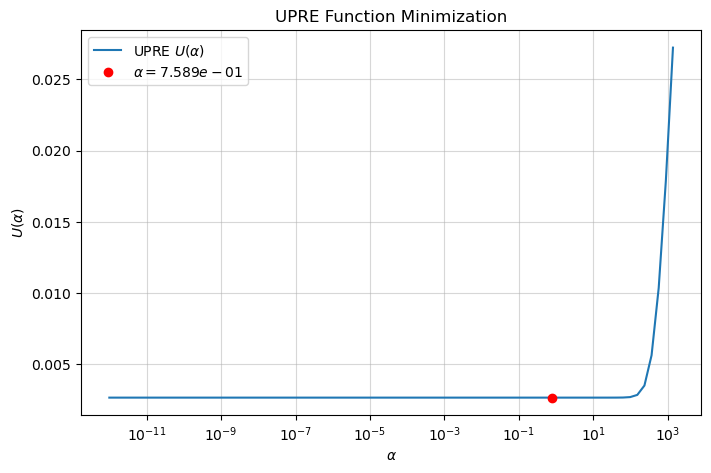

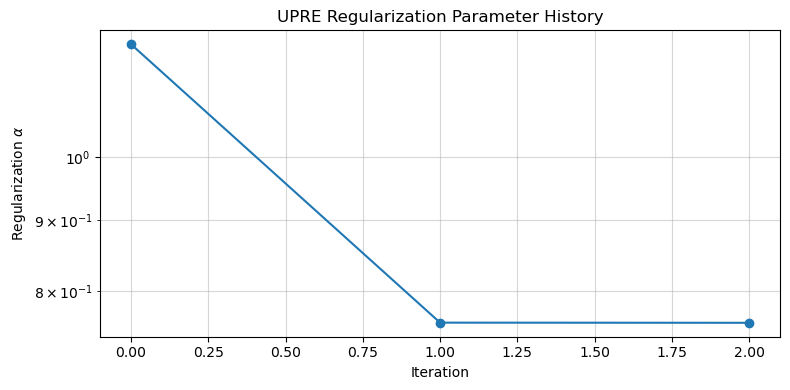

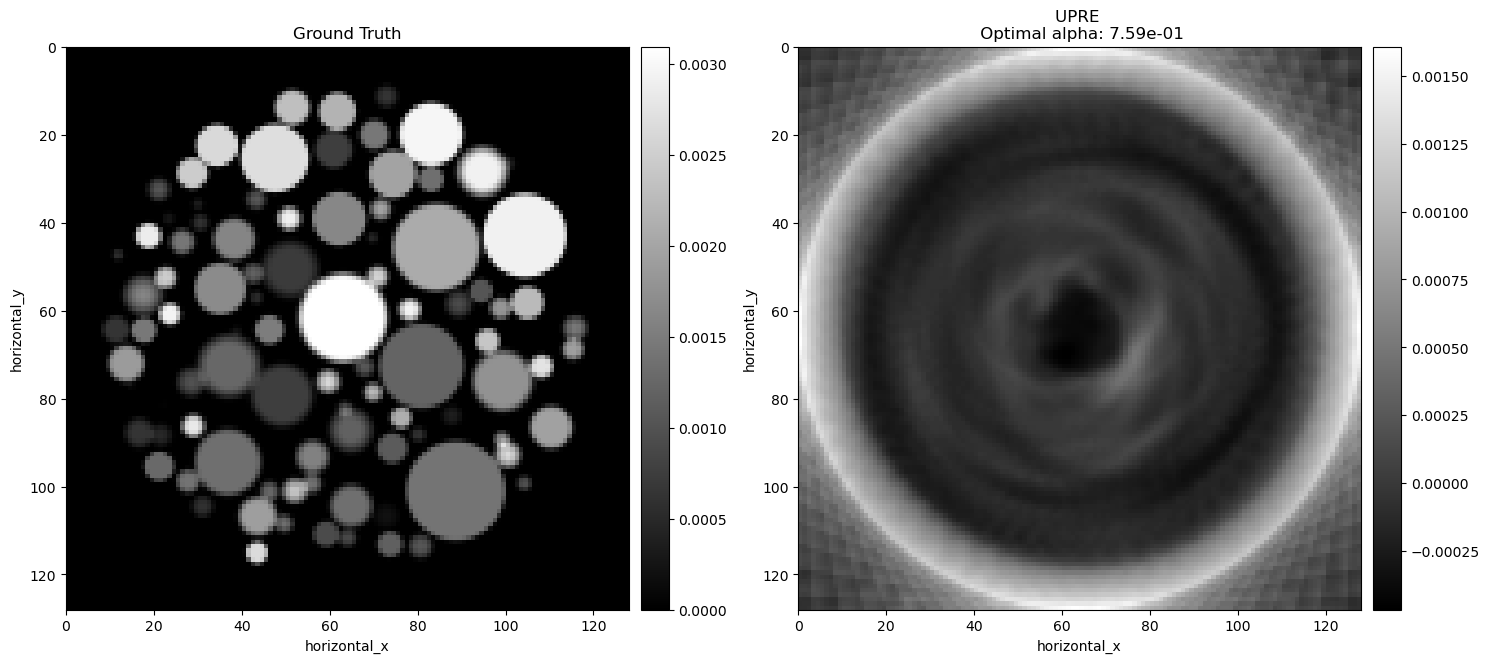

In [48]:
print("The optimal parameter it finds is", hybridlsqrupre.regalpha, "in", hybridlsqrupre.iteration, "iterations")

hybridlsqrupre.reg_rule.plot_function()
try:
    hybridlsqrupre.reg_rule.plot_history()
except:
    pass

show2D([ground_truth, hybridlsqrupre.solution], title = ['Ground Truth', f"UPRE \n Optimal alpha: {hybridlsqrupre.regalpha:.2e}"], origin = 'upper', num_cols = 2)

## 7. L-curve Rule

In [49]:
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                           reg_norm_type='L2', hybrid_reg_rule=lcurve_rule)
t_start = time()
hybridlsqrlcurve.run(maxit, verbose=True)
t_end = time()
print(f"L-curve rule took {t_end - t_start} seconds.")

  0%|          | 0/100 [00:00<?, ?it/s]

L-curve rule took 2.5892131328582764 seconds.


The optimal parameter it finds is 75.14629367847704 in 25 iterations


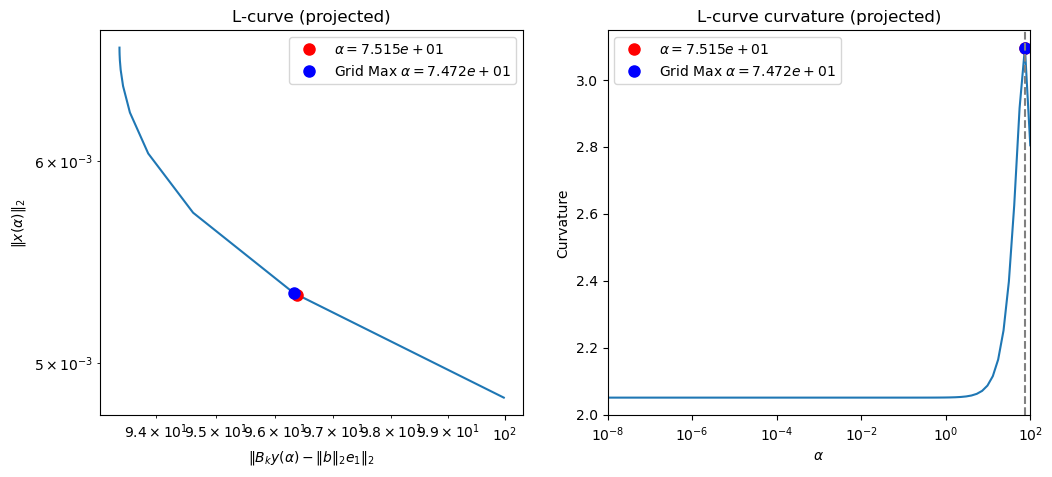

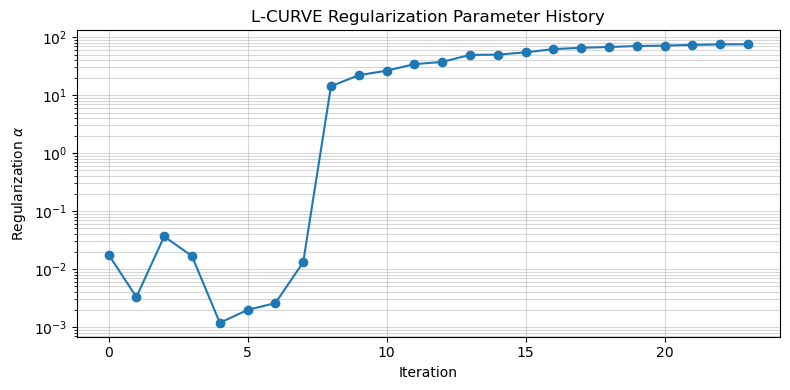

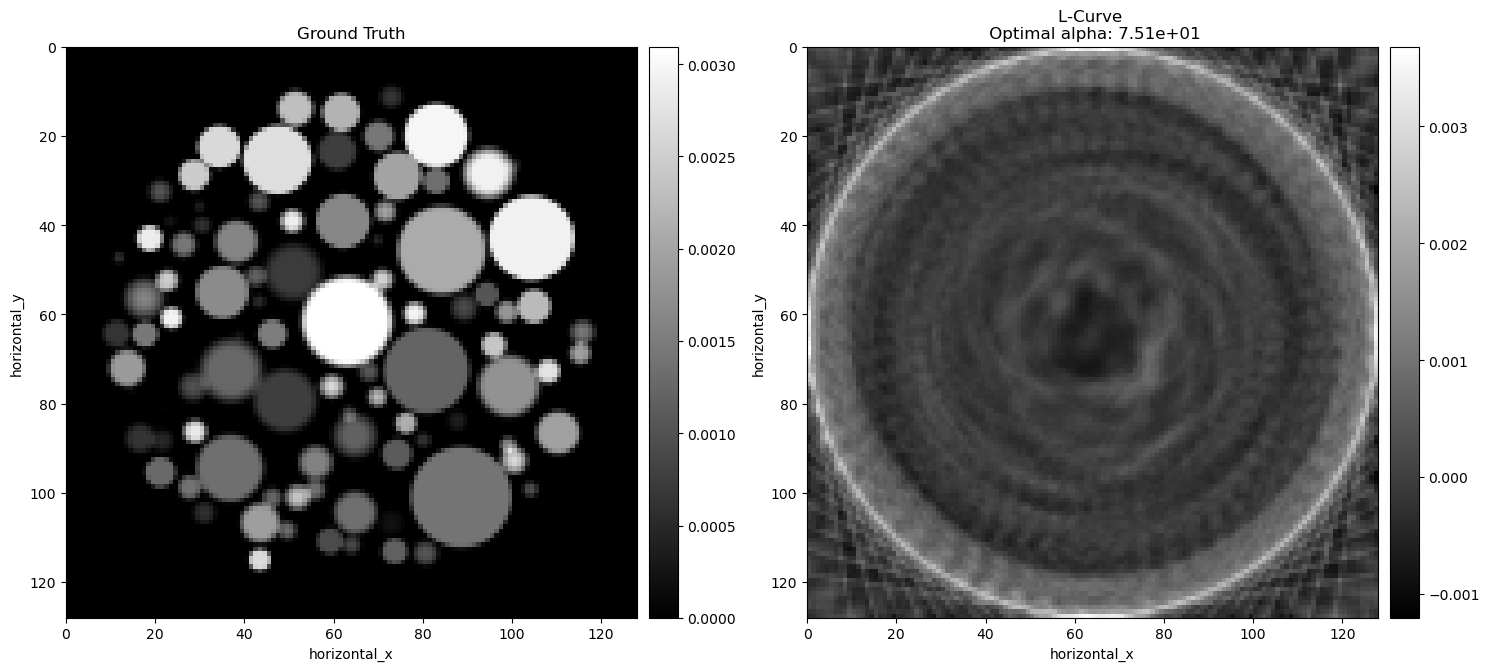

In [50]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))
hybridlsqrlcurve.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrlcurve.solution], title = ['Ground Truth', f"L-Curve \n Optimal alpha: {hybridlsqrlcurve.regalpha:.2e}"], origin = 'upper', num_cols = 2)